In [1]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import torch 
import numpy as np 
import cv2
from modules.VitArchitecture import vit_base_patch16_224 as vit_LRP
from modules.VitArchitecture import LRP, Baselines
from modules.imagenet import CLS2IDX
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
model = vit_LRP(pretrained=True).to(device)
model.eval()
attribution_generator = LRP(model)

methods = ["transformer_attribution", "rollout", "full", 'last_layer', 'second_layer']

In [3]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def generate_visualization(original_image, class_index=None, method="transformer_attribution"):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method=method, index=class_index).detach()
    if transformer_attribution.shape != torch.Size([1, 224, 224]):
        transformer_attribution = transformer_attribution.reshape(1,1,14,14)
        transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    # if use_thresholding:
    #     transformer_attribution = transformer_attribution * 255
    #     transformer_attribution = transformer_attribution.astype(np.uint8)
    #     ret, transformer_attribution = cv2.threshold(transformer_attribution, 0 , 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #     transformer_attribution[transformer_attribution == 255] = 1
    
    image_transformer_attribution = original_image.permute(1 , 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis 

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)




In [ ]:
def compare_indexes(img_path, alt_index=0, method="transformer_attribution"):
    image = Image.open(img_path)
    animal_img = transform(image)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(image)
    axs[0].axis('off')
    output = model(animal_img.unsqueeze(0).cuda())
    print_top_classes(output)
    predicted_class = generate_visualization(animal_img, method=method)
    indexed_class = generate_visualization(animal_img, class_index=alt_index, method=method)
    axs[1].imshow(predicted_class)
    axs[1].axis('off')
    axs[2].imshow(indexed_class)
    axs[2].axis('off')

def compare_methods(img_path, methods):
    image = Image.open(img_path)
    animal_img = transform(image)
    fig, axs = plt.subplots(1, 1 + len(methods), figsize=((1 + len(methods))*4, 4))
    axs[0].imshow(image)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    # axs[0].axis('off')
    axs[0].set_xlabel("Original")
    output = model(animal_img.unsqueeze(0).cuda())
    for i, method in enumerate(methods):
        visualization = generate_visualization(animal_img, method=method)
        axs[i+1].imshow(visualization)
        axs[i+1].set_xticks([])
        axs[i+1].set_yticks([])
        # axs[i+1].axis('off')
        axs[i+1].set_xlabel(method)



# Predicted class is golden retriever (207) and selected index is (285)
compare_indexes('samples/dogcat2.png', 285)

# Predicted class is tusker (101) and selected index is zebra (340)
compare_indexes('samples/el2.png', 340)
compare_indexes('samples/el4.png', 386)
# Predicted class is hammmer (587) and selected index is screwdriver (784)
compare_indexes('samples/hammer.png', 784)

Top 5 classes:
	161 : basset, basset hound         		value = 10.514	 prob = 78.8%
	163 : bloodhound, sleuthhound      		value = 8.604	 prob = 11.7%
	166 : Walker hound, Walker foxhound		value = 7.446	 prob = 3.7%
	162 : beagle                       		value = 5.561	 prob = 0.6%
	168 : redbone                      		value = 5.249	 prob = 0.4%


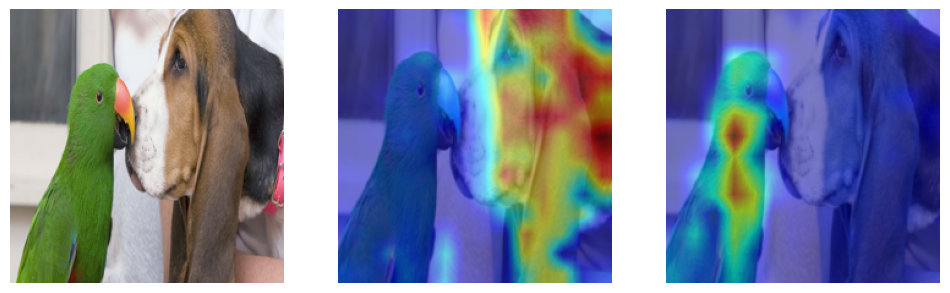

In [16]:
# Prediced class is basset hound (161) and selected index is grey parrot (87)
compare_indexes('samples/dogbird.png', 87)

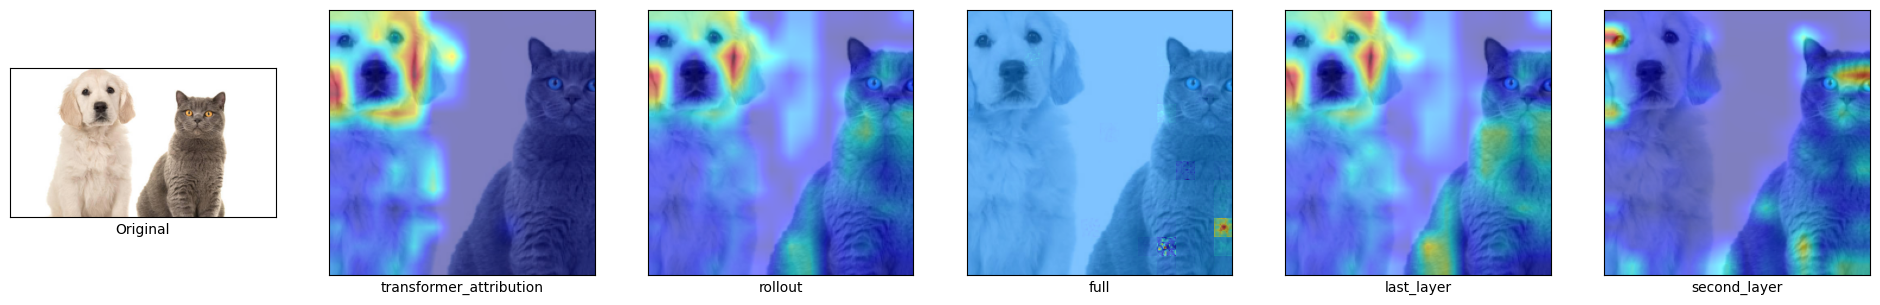

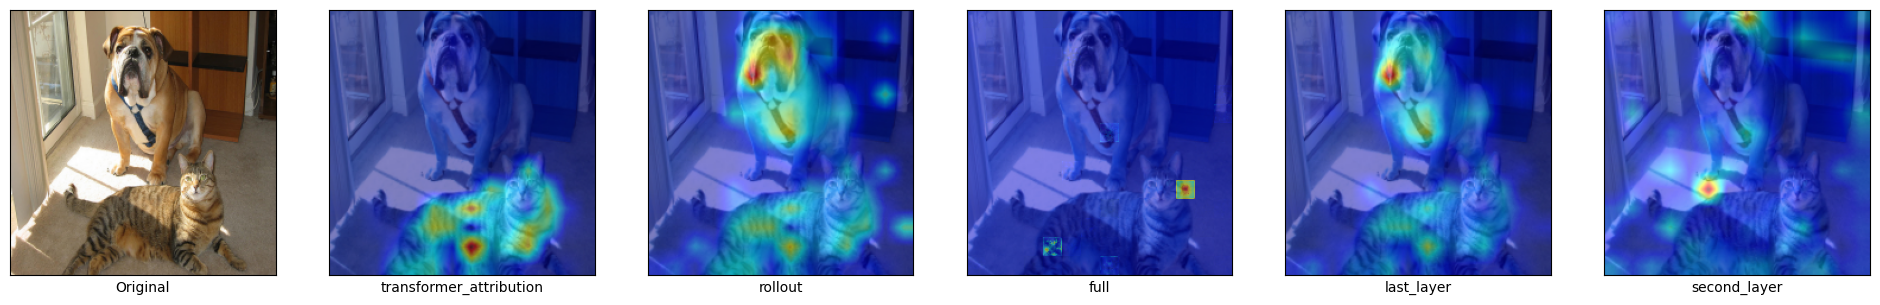

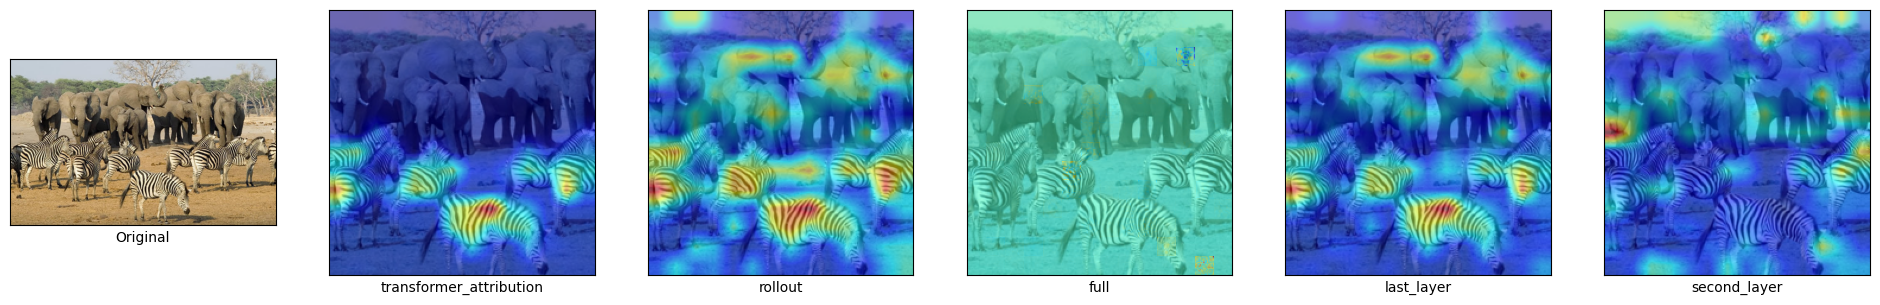

In [6]:
compare_methods('samples/dogcat2.png', methods)
compare_methods('samples/catdog.png', methods)
compare_methods('samples/el4.png', methods)


Top 5 classes:
	953 : pineapple, ananas  		value = 10.493	 prob = 61.4%
	954 : banana             		value = 9.463	 prob = 21.9%
	943 : cucumber, cuke     		value = 8.477	 prob = 8.2%
	939 : zucchini, courgette		value = 7.062	 prob = 2.0%
	949 : strawberry         		value = 6.537	 prob = 1.2%


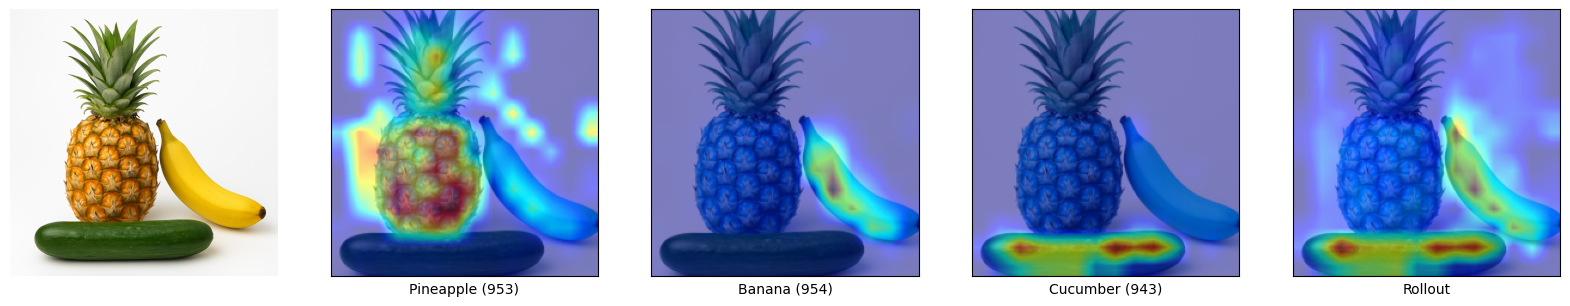

In [15]:
img_path = 'samples/fruits.png'
image = Image.open(img_path).convert("RGB")
animal_img = transform(image)
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

axs[0].imshow(image)
axs[0].axis('off')
output = model(animal_img.unsqueeze(0).cuda())
print_top_classes(output)
rollout_image = generate_visualization(animal_img, method="rollout")
indexed_class1 = generate_visualization(animal_img, class_index=953)
indexed_class2 = generate_visualization(animal_img, class_index=954)
indexed_class3 = generate_visualization(animal_img, class_index=943)
axs[1].imshow(indexed_class1)
axs[1].set_xlabel("Pineapple (953)")
axs[2].imshow(indexed_class2)
axs[2].set_xlabel("Banana (954)")
axs[3].imshow(indexed_class3)
axs[3].set_xlabel("Cucumber (943)")
axs[4].imshow(rollout_image)
axs[4].set_xlabel("Rollout")
for i in range(0, 4):
    axs[i+1].set_xticks([])
    axs[i+1].set_yticks([])
